# Anaysis of Follower-force Buckling Dynamics Data

In [1]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
    
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import interpolate
import pandas as pd

import os
import pyfilaments.analysisutils as analysis
import imp
imp.reload(analysis)
%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm

rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 12})

linux system
dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', '

In [2]:
# Load the file and extract data

# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_k_25_extension_first'

# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_time_sweep_final/activity_timescale_575'
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_time_sweep_final/activity_timescale_1050'
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/2021-12-19'

data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_sweep_FINAL'

# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_time_sweep_30_Jan_2022/activity_timescale_600'


# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/2022-03-03'
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_time_sweep_30_Jan_2022/activity_timescale_750'

# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_time_sweep_30_Jan_2022/activity_timescale_600'

# List all subfolders in the folder
folders = [folder for folder in next(os.walk(data_folder))[1] if 'PredictedDynamics' not in folder and 'FixedPointAnalysis' not in folder]

for ii, folder in enumerate(folders):
    print(ii, folder)

0 SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.103_activityTime_750_simType_point
1 SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.679_activityTime_750_simType_point
2 SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.038_activityTime_750_simType_point
3 SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.949_activityTime_750_simType_point
4 SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205_activityTime_750_simType_point
5 SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.846_activityTime_750_simType_point
6 SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.782_activityTime_750_simType_point
7 SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.295_activityTime_750_simType_point
8 SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.756_activityTime_750_simType_point
9 SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_3.0_activityTime_750_simType_point
10 SimData_Np_32_Shape

# Analysis for Dynamical behavior prediction.
Run all numbered Cells in sequence.

## 1. Run analysis on each filament condition

In [108]:
for folder in folders:
    print(folder)
    
    
    # Load metadata
    df_metadata = pd.read_csv(os.path.join(data_folder, folder, 'metadata.csv'))
    activity_timescale = df_metadata[' activity time scale'][0]
    k = df_metadata['spring constant'][0]
    d0 = df_metadata['potDipole strength'][0]
    print('Activity time', activity_timescale )
    print('PotDipole strength', d0)
    
    files = [file for file in os.listdir(os.path.join(data_folder, folder)) if file.endswith('hdf5')]
    # Allocate arrays to store the data
    init_angle_array = np.zeros(len(files))
    final_angle_array = np.zeros(len(files))
    
    
    # For each condition calculate buckling dynamics at different orientations
    for ii, file in enumerate(files):

        folder, *rest = os.path.split(os.path.join(data_folder, folder, file))
        filament = analysis.analysisTools(file = os.path.join(data_folder, folder, file))

        # Calculate the filament base-tip angle
        filament.compute_base_tip_angle()

        # Calculate the change in base-tip angle over the activity cycle
        
        initial_angle = filament.derived_data['base tip angle'][0]
        final_angle = filament.derived_data['base tip angle'][-1]
        
#         # Correctly handle the case where the filament angle changes sign 
#         # We take the smaller of the two angles (theta, 2pi - theta)
#         if(np.sign(initial_angle)!=np.sign(final_angle)):
#             # If the sign changes 
#             if(abs(final_angle)> 7*np.pi/8):
#                 final_angle = 2*np.pi + final_angle
#             delta_angle[ii] = final_angle - initial_angle
            
            
            
#         else:
#             delta_angle[ii] = final_angle - initial_angle
        
#         if(delta_angle[ii] > 0):
#             delta_angle[ii] = min(delta_angle[ii], 2*np.pi - delta_angle[ii])
#         else:
#             delta_angle[ii] = min(delta_angle[ii], 2*np.pi + delta_angle[ii])
        init_angle_array[ii] = initial_angle
        final_angle_array[ii] = final_angle

    
    # Sort the data based on initial angle
    idx = np.argsort(init_angle_array)

    init_angle_array = init_angle_array[idx]
    final_angle_array = final_angle_array[idx]
            
    print(initial_angle)
            


    title= 'Final angle vs initial angle, d0=' + str(d0)
    plt.figure()
    plt.scatter(init_angle_array, final_angle_array)
    plt.plot(init_angle_array, final_angle_array)
    plt.xlabel('Inital filament angle (rad)')
    plt.ylabel('Final angle (rad)')
    plt.title(title)

    # Save the data as a CSV file
    file_name = 'buckling_escape_angles_{}_{}'.format(activity_timescale, round(d0,3))+'.csv'

    df = pd.DataFrame({'Initial angle (rad)': init_angle_array, 'Final angle (rad)':final_angle_array, 'potDipole strength':np.repeat(round(d0, 3), len(init_angle_array), axis = 0), 'activity timescale':np.repeat(activity_timescale, len(init_angle_array), axis = 0)})

    df.to_csv(os.path.join(data_folder, file_name))

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.103_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.1025641025641018
1.0899403083882915


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.679_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.6794871794871797
1.089940308388297


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.038_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.0384615384615383
1.0899403083882993


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.949_activityTime_750_simType_point
Activity time 750
PotDipole strength 0.9487179487179488
1.0899403083883017


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.205128205128205
1.0899403083882826


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.846_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.846153846153846
1.0899403083882935


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.782_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.782051282051282
1.0899403083882973


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.295_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.2948717948717947
1.089940308388299


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.756_activityTime_750_simType_point
Activity time 750
PotDipole strength 0.7564102564102564
1.0899403083882986


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_3.0_activityTime_750_simType_point
Activity time 750
PotDipole strength 3.0
1.0899403083882917


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.487_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.4871794871794872
1.089940308388291


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.872_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.871794871794872
1.089940308388305


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.974_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.9743589743589745
1.0899403083882917


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.167_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.1666666666666665
1.0899403083882917


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.91_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.91025641025641
1.0899403083883106


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.564_activityTime_750_simType_point
Activity time 750
PotDipole strength 0.5641025641025641
1.0899403083882968


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.628_activityTime_750_simType_point
Activity time 750
PotDipole strength 0.6282051282051282
1.0899403083882908


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.936_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.935897435897436
1.089940308388301


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.269_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.2692307692307692
1.0899403083883015


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.359_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.3589743589743586
1.0899403083882988


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.615_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.6153846153846154
1.0899403083882893


/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.462_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.4615384615384617
1.0899403083883048


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.821_activityTime_750_simType_point
Activity time 750
PotDipole strength 0.8205128205128205
1.0899403083883008


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.5256410256410255
1.089940308388302


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.397_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.3974358974358974
1.089940308388283


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.5_activityTime_750_simType_point
Activity time 750
PotDipole strength 0.5
1.0899403083882957


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.718_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.7179487179487178
1.089940308388301


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.333_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.3333333333333333
1.0899403083882848


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.077_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.0769230769230769
1.0899403083883097


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.551_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.551282051282051
1.0899403083883052


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.743589743589744
1.0899403083882848


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.013_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.0128205128205128
1.0899403083882955


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.885_activityTime_750_simType_point
Activity time 750
PotDipole strength 0.8846153846153846
1.089940308388301


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.654_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.6538461538461535
1.0899403083882997


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.692_activityTime_750_simType_point
Activity time 750
PotDipole strength 0.6923076923076923
1.0899403083882813


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.808_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.8076923076923075
1.0899403083882842


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.423_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.4230769230769234
1.0899403083882924


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.59_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.5897435897435896
1.0899403083882886


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.141_activityTime_750_simType_point
Activity time 750
PotDipole strength 1.1410256410256407
1.0899403083882935


<IPython.core.display.Javascript object>

SimData_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.231_activityTime_750_simType_point
Activity time 750
PotDipole strength 2.230769230769231
1.0899403083882933


<IPython.core.display.Javascript object>

## (Plotting/Optional) Combined Analysis and Plotting across Filament conditions

In [18]:
files = np.sort([file for file in os.listdir(data_folder) if file.endswith('.csv')])


print(files)
df_combined = pd.DataFrame({})
for ii, file in enumerate(files):
    
    if(ii%3==0): # skip every nth condition...
    
        if(file.endswith('csv')):
            df = pd.read_csv(os.path.join(data_folder, file))


            df_combined = df_combined.append(df)


['buckling_escape_angles_750_0.5.csv'
 'buckling_escape_angles_750_0.564.csv'
 'buckling_escape_angles_750_0.628.csv'
 'buckling_escape_angles_750_0.692.csv'
 'buckling_escape_angles_750_0.756.csv'
 'buckling_escape_angles_750_0.821.csv'
 'buckling_escape_angles_750_0.885.csv'
 'buckling_escape_angles_750_0.949.csv'
 'buckling_escape_angles_750_1.013.csv'
 'buckling_escape_angles_750_1.077.csv'
 'buckling_escape_angles_750_1.141.csv'
 'buckling_escape_angles_750_1.205.csv'
 'buckling_escape_angles_750_1.269.csv'
 'buckling_escape_angles_750_1.333.csv'
 'buckling_escape_angles_750_1.397.csv'
 'buckling_escape_angles_750_1.462.csv'
 'buckling_escape_angles_750_1.526.csv'
 'buckling_escape_angles_750_1.59.csv'
 'buckling_escape_angles_750_1.654.csv'
 'buckling_escape_angles_750_1.718.csv'
 'buckling_escape_angles_750_1.782.csv'
 'buckling_escape_angles_750_1.846.csv'
 'buckling_escape_angles_750_1.91.csv'
 'buckling_escape_angles_750_1.974.csv'
 'buckling_escape_angles_750_2.038.csv'
 'bu

In [19]:
df_combined

,Unnamed: 0,Initial angle (rad),Final angle (rad),potDipole strength,activity timescale
0,0,1.950794e-14,1.009173e-14,0.5,750
1,1,3.205707e-02,3.036838e-02,0.5,750
2,2,6.411414e-02,6.076176e-02,0.5,750
3,3,9.617120e-02,9.120296e-02,0.5,750
4,4,1.282283e-01,1.217127e-01,0.5,750
...,...,...,...,...,...
45,45,1.442568e+00,1.794805e+00,3.0,750
46,46,1.474625e+00,1.860835e+00,3.0,750
47,47,1.506682e+00,1.926273e+00,3.0,750
48,48,1.538739e+00,1.991249e+00,3.0,750


In [5]:
parameter = 'potDipole strength'

### (Plotting) Plot the orientation dynamics due to buckling for different filament parameters


<IPython.core.display.Javascript object>


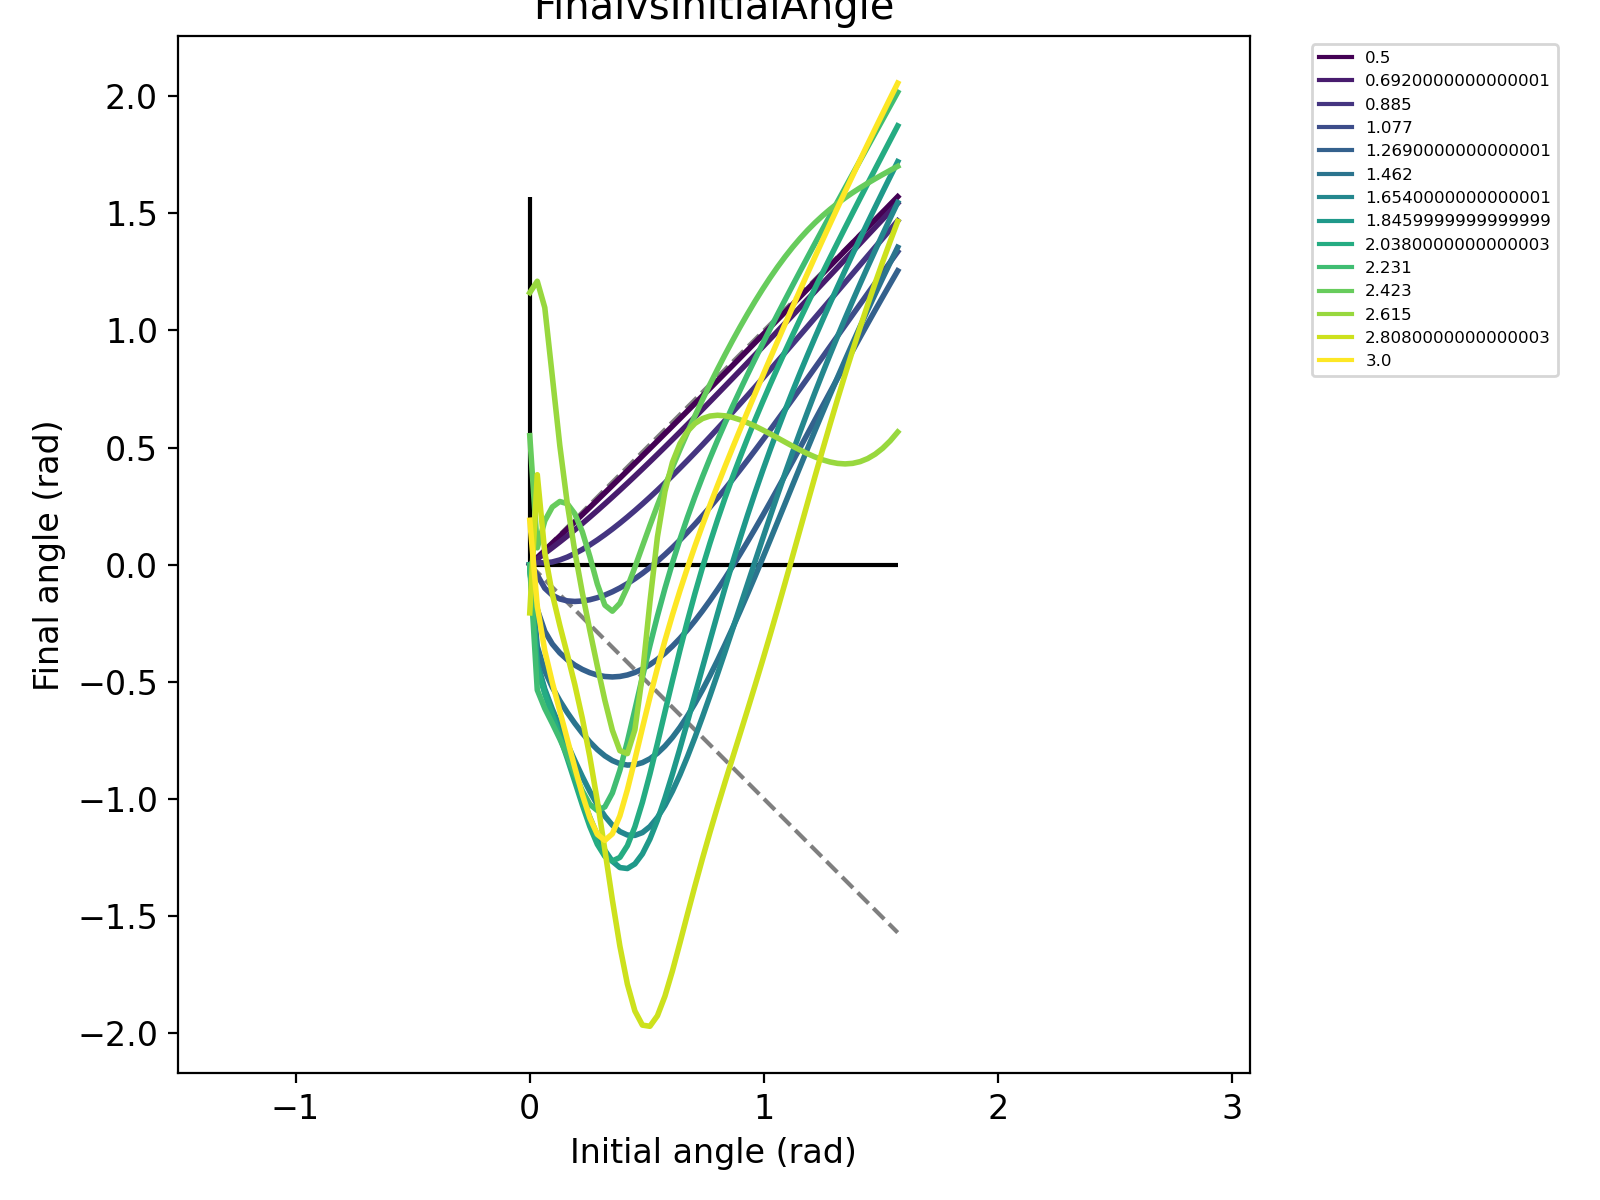

In [28]:
plt.close('all')
from matplotlib.colors import LogNorm
colormap = 'viridis'
file_path = data_folder

title = 'FinalvsInitialAngle'
plt.figure(figsize=(8,6))

# Plot diagonals and guides for detecting fixed points
min_angle = np.min(df_combined['Initial angle (rad)'])
max_angle = np.max(df_combined['Initial angle (rad)'])

plt.hlines(0, min_angle, max_angle, color = 'k', linestyle = '-')
plt.vlines(0, min_angle, max_angle, color = 'k', linestyle = '-')

x_array = np.linspace(min_angle, max_angle, 10)
y_array = x_array

plt.plot(x_array, y_array, color = 'k', linestyle = '--', alpha = 0.5)
plt.plot(x_array, -y_array, color = 'k', linestyle = '--', alpha = 0.5)


sns.lineplot(x='Initial angle (rad)', y = 'Final angle (rad)', hue = parameter,  
             data = df_combined, legend='full', palette = colormap, linewidth = 2)
# sns.scatterplot(x='Initial angle (rad)', y = 'Final angle (rad)', hue = 'd0',  
#              data = df_combined, palette = 'mako', legend = False)
ax = plt.gca()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',prop={'size': 6})
plt.tight_layout()
plt.title(title)


plt.axis('equal')


# plt.savefig(os.path.join(file_path,title + '.png'), dpi = 300)
# plt.savefig(os.path.join(file_path,title + '.svg'), dpi = 300)

plt.show()


In [30]:
# Reflect the plot about X and Y to see the full return map of filament orientation

df_combined['-Initial angle (rad)'] = -df_combined['Initial angle (rad)']
df_combined['-Final angle (rad)'] = -df_combined['Final angle (rad)']

<IPython.core.display.Javascript object>


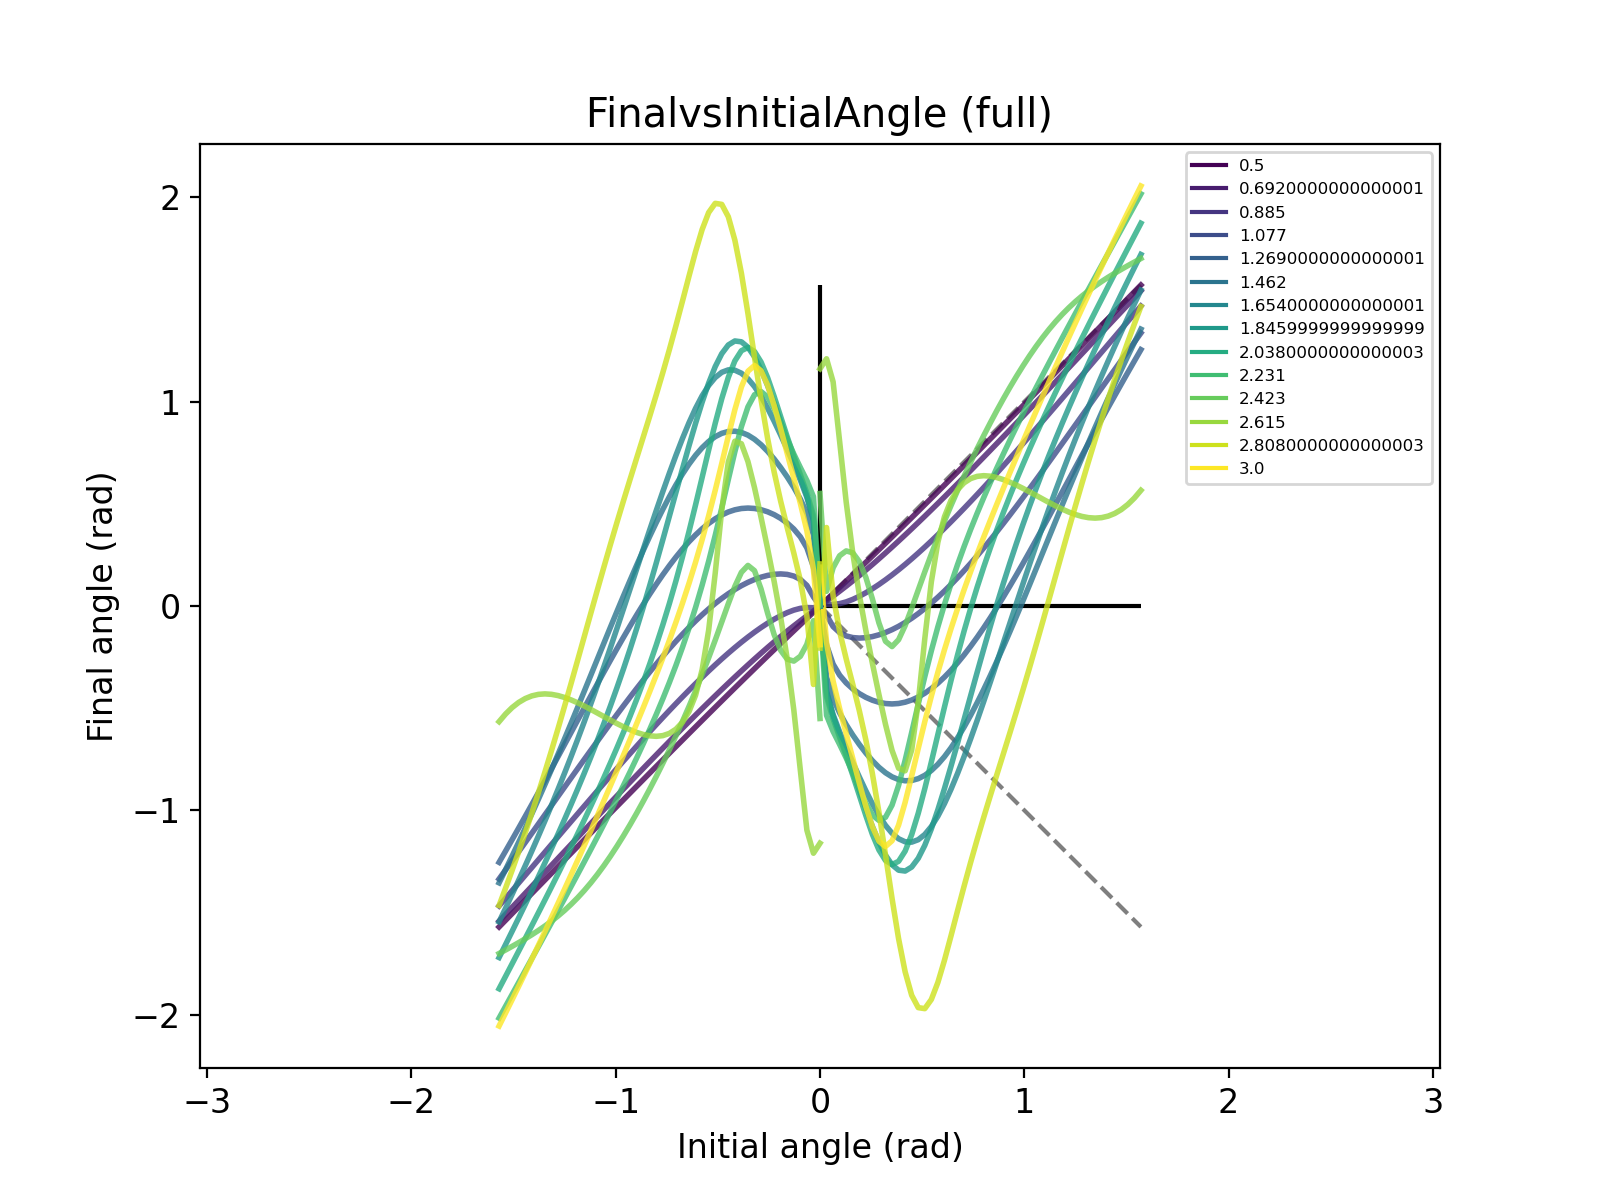

In [35]:
# Plot the overall distribution (for both +ve and -ve initial angles)

title = 'FinalvsInitialAngle (full)'
colormap = 'viridis'
alpha = 0.8

plt.figure(figsize=(8,6))

# Plot diagonals and guides for detecting fixed points
min_angle = -np.max(df_combined['Initial angle (rad)'])
max_angle = np.max(df_combined['Initial angle (rad)'])

# Plot diagonals and guides for detecting fixed points
min_angle = np.min(df_combined['Initial angle (rad)'])
max_angle = np.max(df_combined['Initial angle (rad)'])

plt.hlines(0, min_angle, max_angle, color = 'k', linestyle = '-')
plt.vlines(0, min_angle, max_angle, color = 'k', linestyle = '-')

x_array = np.linspace(min_angle, max_angle, 10)
y_array = x_array

plt.plot(x_array, y_array, color = 'k', linestyle = '--', alpha = 0.5)
plt.plot(x_array, -y_array, color = 'k', linestyle = '--', alpha = 0.5)

sns.lineplot(x='Initial angle (rad)', y = 'Final angle (rad)', hue = parameter,  
             data = df_combined, legend='full', palette = colormap, linewidth = 2, alpha = alpha)
sns.lineplot(x='-Initial angle (rad)', y = '-Final angle (rad)', hue = parameter,  
             data = df_combined, legend=False, palette = colormap, linewidth = 2, alpha = alpha)
# sns.scatterplot(x='Initial angle (rad)', y = 'Final angle (rad)', hue = 'd0',  
#              data = df_combined, palette = 'mako', legend = False)
ax = plt.gca()
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='best')
plt.legend(loc='best', prop={'size': 6})

# plt.tight_layout()
plt.title(title)


# plt.tight_layout()
plt.axis('equal')
plt.savefig(os.path.join(file_path,title + '.png'), dpi = 300)
plt.savefig(os.path.join(file_path,title + '.svg'), dpi = 300)

plt.show()


# Fixed-points Analysis

## Find the Fixed-points and analyze their Stability

In [58]:
def find_fixed_points(x, f):
    ''' Given an array x and f which is f(x) evaluated over the array then find all the fixed points
        f(x) = x
    '''
    N = len(x)
    
    indices = []
    for ii in range(N-1):
        if((x[ii]-f[ii]<=0 and x[ii+1] - f[ii+1]>0) or (x[ii]-f[ii]>=0 and x[ii+1]-f[ii+1]<0)):
            indices.append(ii+1)
           
    fixed_points = x[indices]
    
    return indices, fixed_points
    

def find_slope(x, f, x_slope):
    '''
         Given an array x and f which is f(x) evaluated over the array 
         Find the slope f'(x) evaluated at x_slope
    '''
    
    # Evaluate the slope of the function
    gradient = np.gradient(f, x)
    assert(len(gradient) == len(f))
    
    return gradient[x_slope]
    

## 2. Trawl through the data folder and find fixed points and slope

<IPython.core.display.Javascript object>


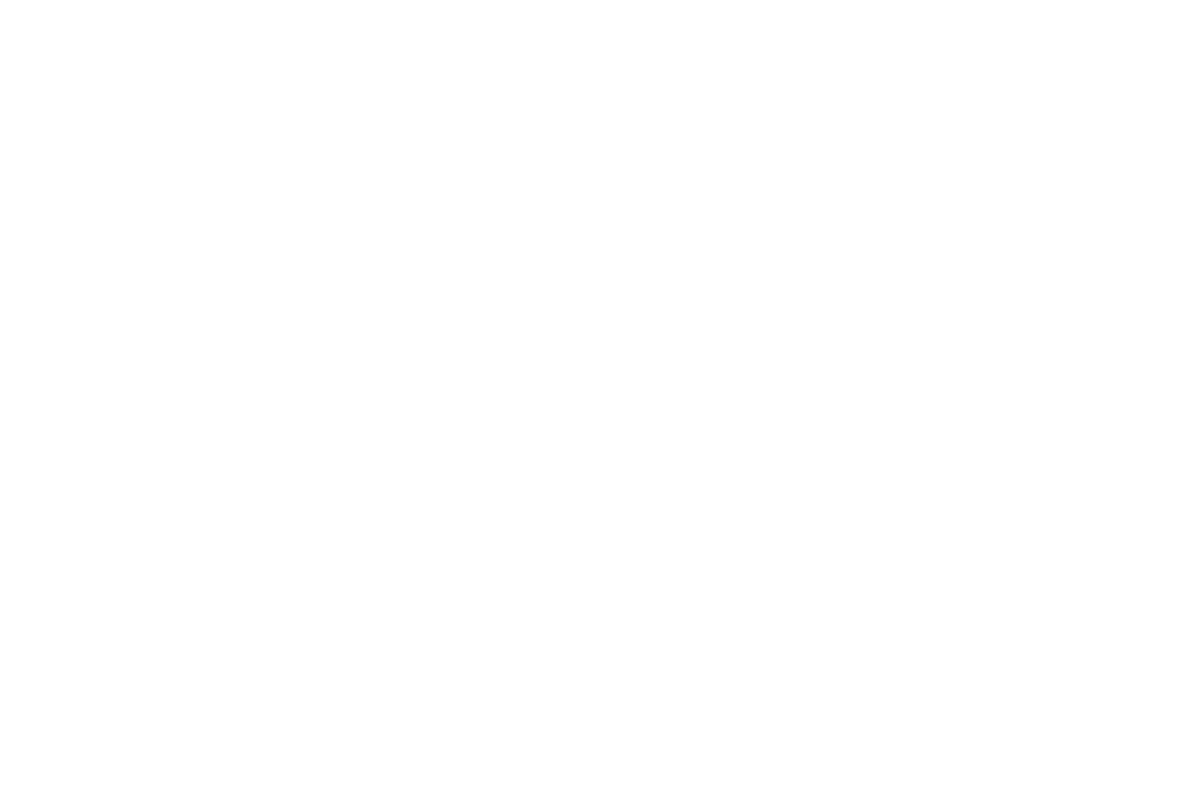

IndexError: index 199 is out of bounds for axis 0 with size 100

In [66]:
# Better implementation to avoid issues with zero-fixed point analysis

from scipy import interpolate


files = os.listdir(data_folder)

parameter = 'potDipole strength'
parameter_1 = 'activity timescale'


analysis_folder = os.path.join(data_folder, 'FixedPointAnalysis')

if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

plt.figure(figsize = (6,4))
title = 'Fixed-point analysis'

for ii, file in enumerate(files):
    
    if(file.endswith('csv')):
        
        df = pd.read_csv(os.path.join(data_folder, file))
        
        parameter_value = df[parameter][0]
        
        parameter_value_1 = df[parameter_1][0]
        
        
        initial_angle_array = np.array(df['Initial angle (rad)'])
        final_angle_array = np.array(df['Final angle (rad)'])
        
        initial_angle_array_neg = -init_angle_array
        final_angle_array_neg = -final_angle_array
        
        initial_angle_array_full = np.concatenate((initial_angle_array_neg, initial_angle_array))
        final_angle_array_full = np.concatenate((final_angle_array_neg, final_angle_array))
        
        idx = np.argsort(initial_angle_array_full)
        
        initial_angle_array_full = initial_angle_array_full[idx]
        final_angle_array_full = final_angle_array_full[idx]
        
        
        min_angle, max_angle = np.min(initial_angle_array_full), np.max(initial_angle_array_full)
        
        initial_angle_array_fine = np.linspace(min_angle, max_angle, 10000)
        
        min_angle, max_angle = np.min(initial_angle_array_fine), np.max(initial_angle_array_fine)
        
      
        
        final_angle_func = interpolate.interp1d(initial_angle_array_full, final_angle_array_full, kind = 'linear')
        
        final_angle_array_fine = final_angle_func(initial_angle_array_fine)
        
    
        # Fixed points of f(x) = x
        fixed_points_pos_index, fixed_points_pos = find_fixed_points(initial_angle_array_fine, final_angle_array_fine)
        # Fixed points of f(x)=-x
        fixed_points_neg_index, fixed_points_neg = find_fixed_points(-initial_angle_array_fine, final_angle_array_fine)
        
     
        
        # Find the slope at the fixed-point
        gradient_pos_fixed_points = find_slope(initial_angle_array_fine, 
                                               final_angle_array_fine, fixed_points_pos_index)
        
        gradient_neg_fixed_points = find_slope(initial_angle_array_fine, 
                                               final_angle_array_fine, fixed_points_neg_index)
        
#         gradient_zero_fixed_points = find_slope(initial_angle_array_fine, 
#                                                 final_angle_array_fine, 0)

       
        
        # Plot the Return maps along with the fixed points
        sns.lineplot(x= initial_angle_array_fine, y = final_angle_array_fine, legend='full', 
                     palette = colormap, linewidth = 2, label = parameter_value)
        plt.scatter(initial_angle_array_fine[fixed_points_neg_index], fixed_points_neg, 20, color = 'k')
        plt.scatter(initial_angle_array_fine[fixed_points_pos_index], fixed_points_pos, 20, color = 'r')
        
        
        # For each condition store the fixed points, their type and the slope
        df_fixed_pts_analysis = pd.DataFrame({})

        for ii, fixed_pt in enumerate(fixed_points_pos):
            if(abs(fixed_pt)<=1e-3):
                fixed_pt=0
                
            if(fixed_pt>=0):
                # Due to symmetry it's enough to keep only the positive fixed points
                df_fixed_pts_analysis = df_fixed_pts_analysis.append(pd.DataFrame({'Fixed point':[fixed_pt], 'Slope':[gradient_pos_fixed_points[ii]], 'type':['Positive'], parameter:[parameter_value], parameter_1:[parameter_value_1]}))
        
        for ii, fixed_pt in enumerate(fixed_points_neg):
            if(fixed_pt>=0):
                # Due to symmetry it's enough to keep only the positive fixed points
                df_fixed_pts_analysis = df_fixed_pts_analysis.append(pd.DataFrame({'Fixed point':[fixed_pt], 'Slope':[gradient_neg_fixed_points[ii]], 'type':['Negative'], parameter:[parameter_value], parameter_1:[parameter_value_1]}))

        
     
        # Zero is always a fixed point
#         df_fixed_pts_analysis = df_fixed_pts_analysis.append(pd.DataFrame({'Fixed point':[0], 'Slope':[gradient_zero_fixed_points], 'type':['Trivial'], parameter:[parameter_value]}))

            
        
        df_fixed_pts_analysis.to_csv(os.path.join(analysis_folder, 'FixedPoints_{}_{}.csv'.format(parameter, parameter_value)))
        
plt.hlines(0, min_angle, max_angle, color = 'k', linestyle = '--')
plt.vlines(0, min_angle, max_angle, color = 'k', linestyle = '--')

x_array = np.linspace(min_angle, max_angle, 10)
y_array = x_array

plt.plot(x_array, y_array, color = 'k')
plt.plot(x_array, -y_array, color = 'k')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',prop={'size': 6})
# plt.tight_layout()
plt.title(title)
plt.show()



In [76]:
df_fixed_pts_analysis

,Fixed point,Slope,type,potDipole strength
0,0.000000,1.569860,Positive,1.026
0,0.032872,-0.560556,Positive,1.026


In [60]:
# For each condition load the fixed points and their slope and analyze the Dynamical behavior of the system.

# Load a test file
# fixed_pt_file = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_sweep_FINAL/FixedPointAnalysis/FixedPoints_potDipole strength_1.526.csv'

# df_fixed_pt = pd.read_csv(fixed_pt_file)


def dynamical_behavior_predictor(fixed_pt, slope, pt_type):
    '''
    Given the fixed_pt, slope and 
    type of fixed pt 
    f(x) = x: Positive or f(x) = -x: Negative
    
    Returns: behavior Type, Stability
    Type of dynamical behavior expected.
    Types:
    - Trivial fixed point
    - 1-Period cycle
    - 2-Period cycle
    
    Stability:
    - Stable
    - Unstable
    
    '''
    dynamical_behavior = None
    stability = None
    
    if fixed_pt==0:
        dynamical_behavior = 'Zero fixed point'
    
    if fixed_pt!=0:
        
        if pt_type == 'Positive':
            
            dynamical_behavior = '1-Period'
        
        elif pt_type == 'Negative':
            dynamical_behavior = '2-Period'
        
    if abs(slope) > 1:
        stability = 'unstable'
    elif abs(slope) < 1:
        stability = 'linearly stable'
    elif abs(slope)==1:
        stability = 'marginal'
            
    return dynamical_behavior, stability
            
    
# df_fixed_pt


## 3. Calculate and plot the dynamical behaviors for all the data
Save the predicted dynamical behavior and stability in the same file

In [61]:
analysis_folder = os.path.join(data_folder, 'FixedPointAnalysis')

files = os.listdir(analysis_folder)

for ii, file in tqdm(enumerate(files)):
    
    print(ii)
    df = pd.read_csv(os.path.join(analysis_folder, file))
    
#     df['dynamics'] = []
#     df['stability'] = []

    dynamics_list = []
    stability_list = []
    for jj in range(len(df)):
        
        fixed_pt, slope,  pt_type = df['Fixed point'][jj], df['Slope'][jj], df['type'][jj] 
        
        dynamical_behavior, stability = dynamical_behavior_predictor(fixed_pt, slope, pt_type)
        
        dynamics_list.append(dynamical_behavior)
        stability_list.append(stability)
        
    df['dynamics'] = dynamics_list
    df['stability'] = stability_list
        
    # Save the DataFrame back to disk
    df.to_csv(os.path.join(analysis_folder, file), index = False)



2it [00:00, 287.24it/s]

0
1


## 4. For each unique parameter value analyze the fixed-points and tabulate the stable, unstable and predicted dynamics 
The predicted dynamics is the stable dynamics if found, if not we predict the dynamics to be 'Aperiodic'

In [62]:
analysis_folder = os.path.join(data_folder, 'FixedPointAnalysis')

files = os.listdir(analysis_folder)

df_combined = pd.DataFrame({})

for ii, file in enumerate(files):
    
    df = pd.read_csv(os.path.join(analysis_folder, file))
    
    df_combined = df_combined.append(df)
    
    

# Parameter value(s) of interest.
parameter = 'potDipole strength'
parameter_1 = 'activity timescale'

unique_parameter_values = np.unique(df_combined[parameter][:])

parameter_value_1 = np.unique(df_combined[parameter_1][:])


df_predicted_behavior = pd.DataFrame({})

for parameter_value in unique_parameter_values:
    
    stable_dynamics = []
    unstable_dynamics = []
    predicted_dynamics = []
    
    df = df_combined.loc[df_combined[parameter]==parameter_value]
    
    print(df)
    
    if np.all(df['stability']=='unstable'):
        predicted_dynamics = 'Aperiodic'
    
    for ii in range(len(df)):

        if(df['stability'][ii]=='linearly stable'):
            stable_dynamics = df['dynamics'][ii]
            predicted_dynamics = stable_dynamics

        elif(df['stability'][ii] == 'unstable' and df['type'][ii]!='Trivial'):
            unstable_dynamics.append(df['dynamics'][ii])
            
    
    df_predicted_behavior = df_predicted_behavior.append(pd.DataFrame({parameter: [parameter_value], parameter_1:parameter_value_1,
       'Stable dynamics':[stable_dynamics], 'Unstable dynamics':[unstable_dynamics], 'Predicted dynamics':[predicted_dynamics]}))

   Unnamed: 0  Fixed point       Slope      type  potDipole strength  \
0           0       0.0000  195.460156  Positive                 2.0   
1           0       0.2466   -0.692368  Positive                 2.0   

   activity timescale          dynamics        stability  
0                 600  Zero fixed point         unstable  
1                 600          1-Period  linearly stable  
   Unnamed: 0  Fixed point        Slope      type  potDipole strength  \
0           0     0.000000  2240.365445  Positive                 2.5   
1           0     0.088013    -0.711473  Positive                 2.5   

   activity timescale          dynamics        stability  
0                 600  Zero fixed point         unstable  
1                 600          1-Period  linearly stable  


In [63]:
df_predicted_behavior

,potDipole strength,activity timescale,Stable dynamics,Unstable dynamics,Predicted dynamics
0,2.0,600,1-Period,[Zero fixed point],1-Period
0,2.5,600,1-Period,[Zero fixed point],1-Period


## 5. Save/Load the predicted dynamicsfile

In [87]:
predicted_dynamics_folder = os.path.join(data_folder, 'PredictedDynamics')

if not os.path.exists(predicted_dynamics_folder):
    os.makedirs(predicted_dynamics_folder)

predicted_dynamics_file = os.path.join(predicted_dynamics_folder, 'PredictedDynamics.csv')

if not os.path.exists(predicted_dynamics_file):
    df_predicted_behavior.to_csv(predicted_dynamics_file, index = False)
else:
    
    df_predicted_behavior = pd.read_csv(predicted_dynamics_file)
        

## Plot the predicted dynamics vs the parameter

<IPython.core.display.Javascript object>


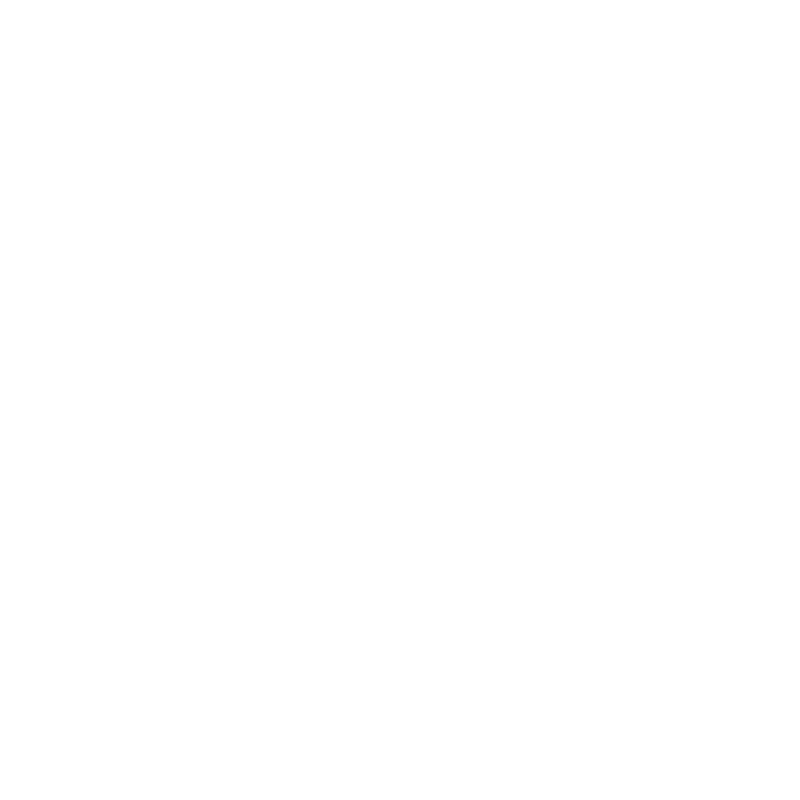

<IPython.core.display.Javascript object>


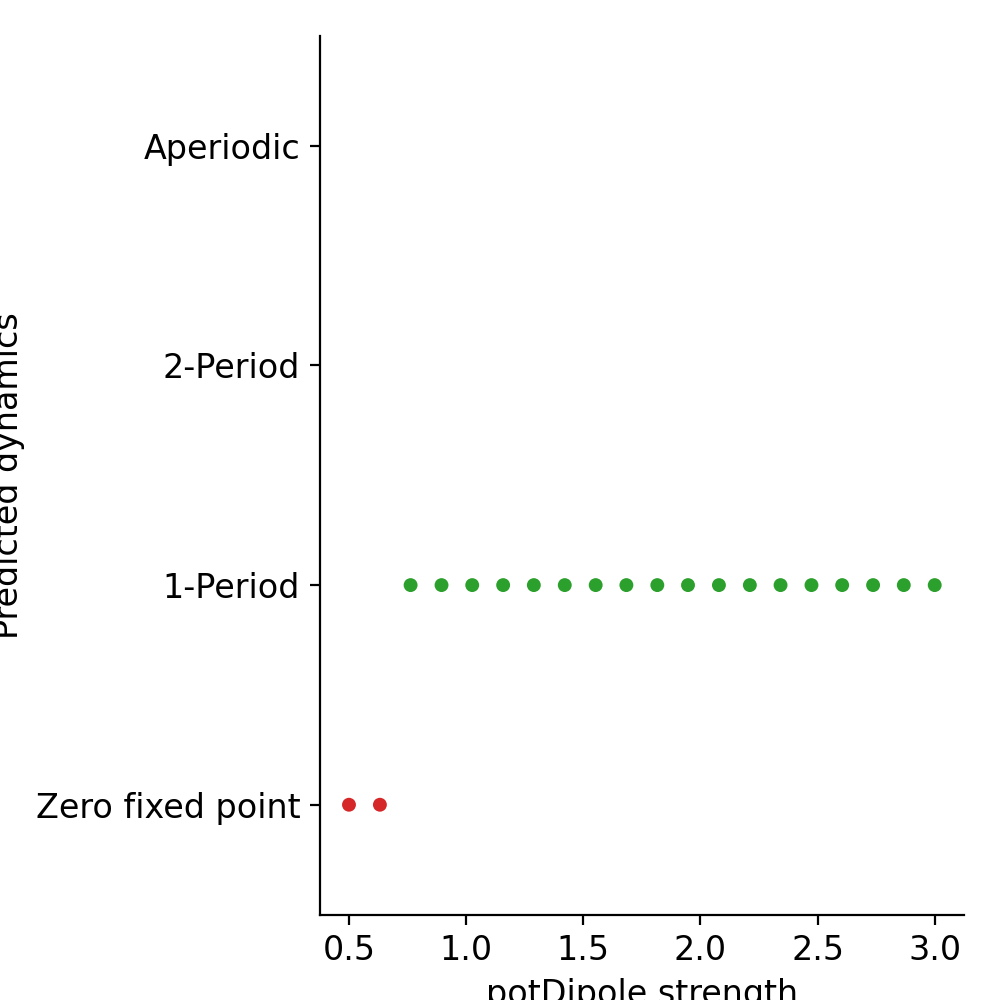

In [88]:
plt.close('all')

plt.figure(figsize = (4,4))
sns.catplot(data = df_predicted_behavior, x = parameter, y = 'Predicted dynamics', order=["Aperiodic", "2-Period", "1-Period", "Zero fixed point"], jitter = False)

plt.show()



## Plot the Return-Map for a single value of the parameter

<IPython.core.display.Javascript object>


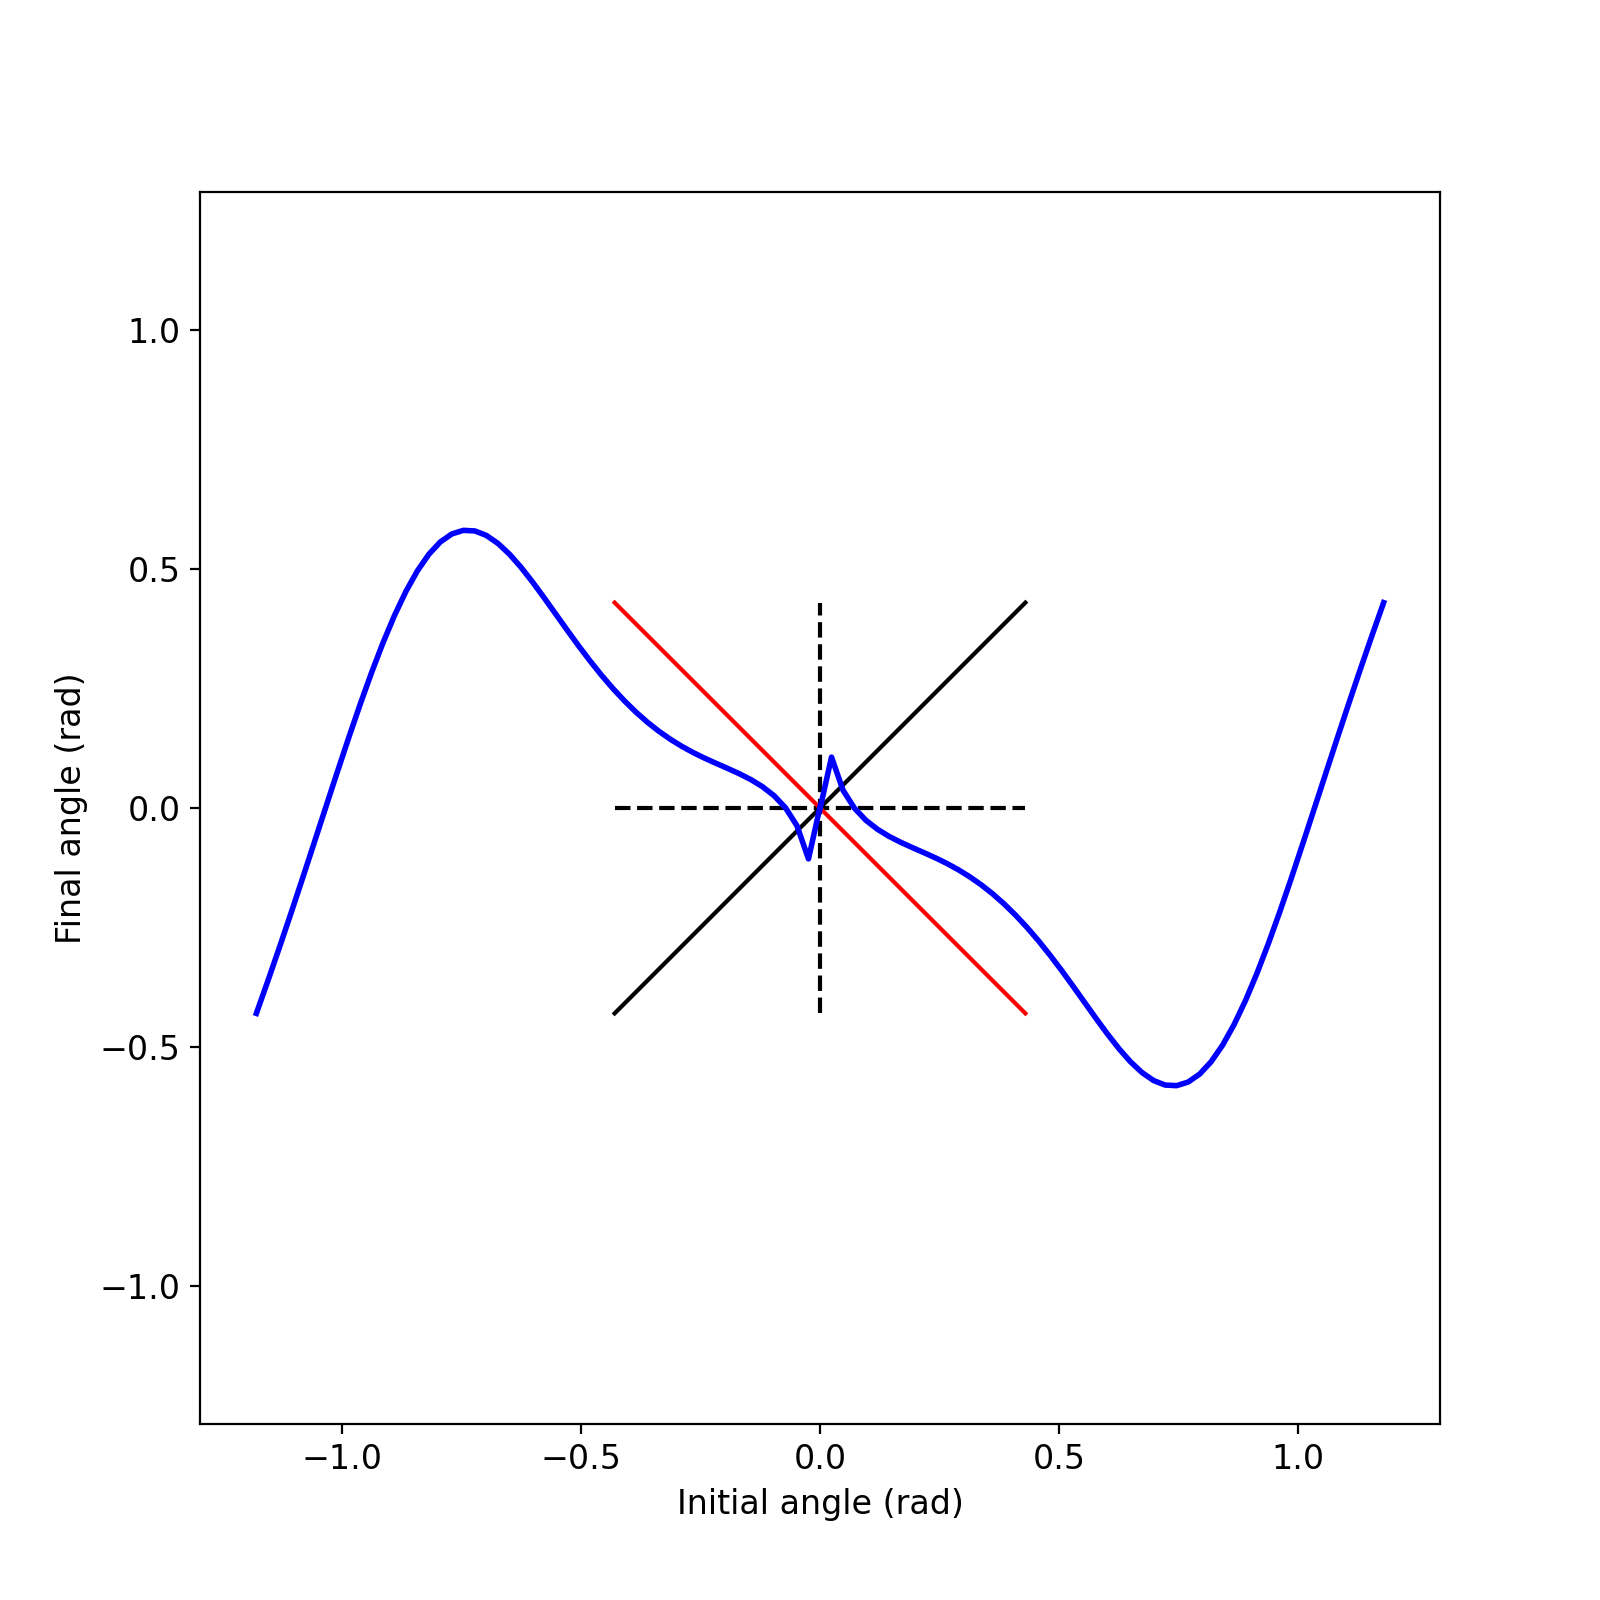

(-1.2959069696057952,
 1.2959069696057952,
 -0.6383976196368173,
 0.6383976196368173)

In [47]:

# file = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_k_25_extension_first/buckling_escape_angles_750_1.947.csv'

# file = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_k_25_extension_first/buckling_escape_angles_750_2.079.csv'
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_sweep_FINAL/buckling_escape_angles_750_2.487.csv'
file = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_time_sweep_30_Jan_2022/activity_timescale_600/buckling_escape_angles_600_2.474.csv'

# file = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/2022-03-02/buckling_escape_angles_600_2.474.csv'
df = pd.read_csv(file)

df['-Initial angle (rad)'] = -df['Initial angle (rad)']
df['-Final angle (rad)'] = -df['Final angle (rad)']

min_angle, max_angle = -np.max(df['Final angle (rad)']), np.max(df['Final angle (rad)'])
plt.figure(figsize = (8,8))

plt.hlines(0, min_angle, max_angle, color = 'k', linestyle = '--')
plt.vlines(0, min_angle, max_angle, color = 'k', linestyle = '--')

x_array = np.linspace(min_angle, max_angle, 10)
y_array = x_array

plt.plot(x_array, y_array, color = 'k')
plt.plot(x_array, -y_array, color = 'r')


sns.lineplot(x='Initial angle (rad)', y = 'Final angle (rad)',  
             data = df, legend='full', color = 'b', linewidth = 2)
sns.lineplot(x='-Initial angle (rad)', y = '-Final angle (rad)',  
             data = df, legend='full', color = 'b', linewidth = 2)

plt.axis('equal')
# plt.savefig('ReturnMap_aperiodic.png', dpi = 300)

# Alternate representations of the orientation velocity vs orientation

-84.86819670142373
74.84952729398748


<IPython.core.display.Javascript object>


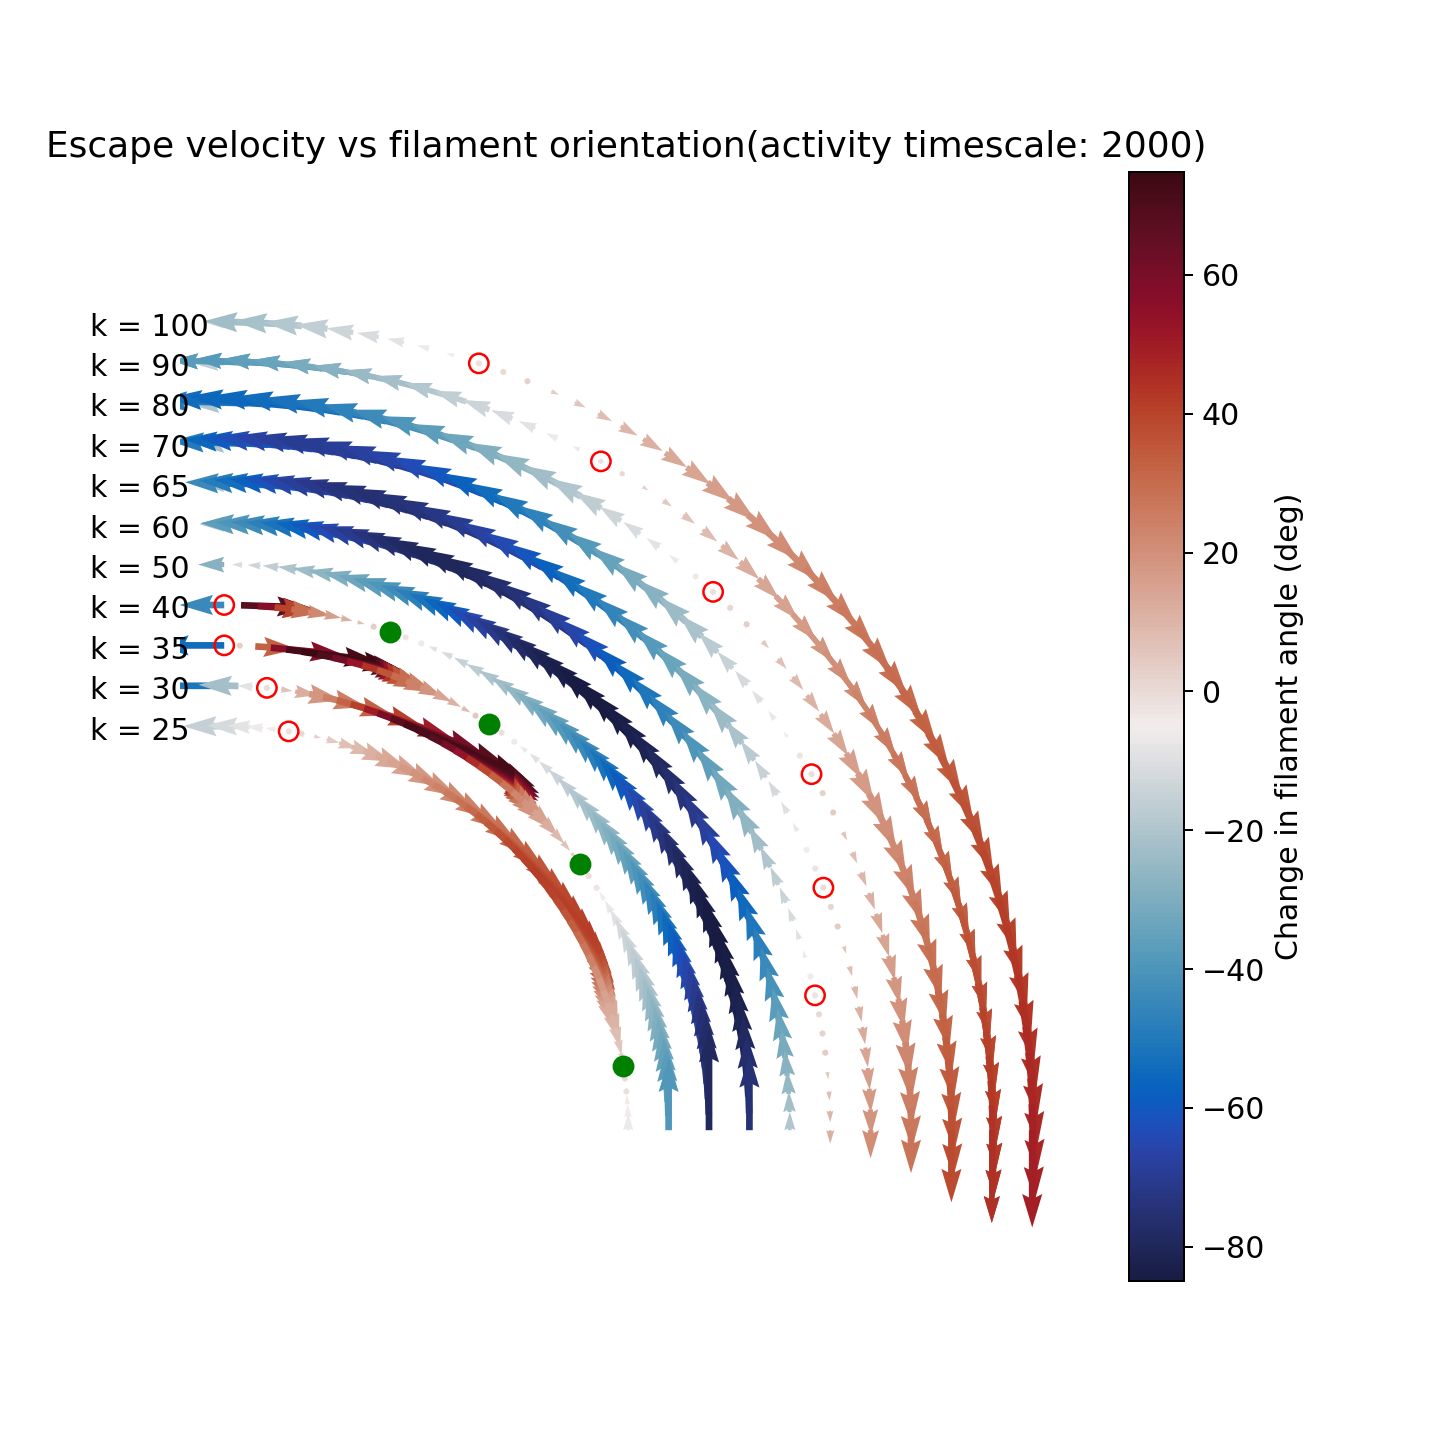

[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[ 1. -1.]
[]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]


In [268]:
import cmocean
import matplotlib as mpl
file_path = analysis_data_folder

# Plotting it as a polar quiver plot
# Assign a distinct radius for each filament stiffness

delta_min = np.min(df_combined['Delta angle (deg)'])
delta_max = np.max(df_combined['Delta angle (deg)'])

print(delta_min)
print(delta_max)

norm = mpl.colors.Normalize(vmin= delta_min, vmax=delta_max)

cm = cmocean.cm.balance

sm = mpl.cm.ScalarMappable(cmap=cm, norm=norm)

plt.figure(figsize=(8,8))
for jj, k in enumerate(spring_constants_to_plot):
    
    df = df_combined[df_combined['spring constant'] == k]
    
    R = 30 + 3*jj
    vx = df['Delta angle (deg)']*np.cos(np.pi/180*df['Initial angle (deg)'])
    vy = -df['Delta angle (deg)']*np.sin(np.pi/180*df['Initial angle (deg)'])
    
    x = R*np.sin(np.pi/180*df['Initial angle (deg)'])
    y = R*np.cos(np.pi/180*df['Initial angle (deg)'])
    
    # Detect fixed-points of Delta angle
    fixed_points = np.where(np.diff(np.sign(df['Delta angle (deg)'])))[0]
    
    # Detect if fixed points are "Stable" or "Unstable"
    stability = np.sign(np.diff(df['Delta angle (deg)'])[fixed_points])
    print(stability)
    
    
    color_data = np.array(df['Delta angle (deg)'])
    
    plt.quiver(x, y, vx, vy, color = cm(norm(color_data)))
    plt.text(x[0]-10, y[0]-1, 'k = '+str(k))
    for ii, fixed_point in enumerate(fixed_points):
        if(stability[ii] > 0):
            # Unstable fixed point
            plt.scatter(x[fixed_point], y[fixed_point], 60, facecolors='none', edgecolors='r')
        elif(stability[ii] < 0):
            # Stable fixed point
            plt.scatter(x[fixed_point], y[fixed_point], 60, color = 'g')
   
cbar = plt.colorbar(sm)
plt.axis('equal')
plt.axis('off')
plt.xlabel('X')
plt.xlabel('Y')
cbar.ax.set_ylabel('Change in filament angle (deg)')
plt.title('Escape velocity vs filament orientation' + '(activity timescale: {})'.format(df['activity time'][0]))
plt.savefig(os.path.join(file_path, 'Escape velocity vs filament orientation_activity_time_{}.png'.format(df['activity time'][0])), dpi = 300)
plt.savefig(os.path.join(file_path, 'Escape velocity vs filament orientation_activity_time_{}.svg'.format(df['activity time'][0])), dpi = 300)

plt.show()
    

In [206]:
A = np.random.rand(10)
B = np.zeros(len(A))
B = np.any(A<0.5)

In [207]:
print(B)

True


In [209]:
1!=1

False